In [1]:
import mne
import mne.io

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns

%matplotlib inline

In [3]:
data_path = "/home/pfilipia/inria/chu_nice_inria/patients_ecog"
patient_path_prefix = data_path + "/patient03/20180801_1354"

events_data = pd.read_csv(
    "%s_events.csv" % patient_path_prefix, header=0
)

raw = mne.io.read_raw_brainvision(
    vhdr_fname="%s_brainvision.vhdr" % patient_path_prefix, montage=None
)

Extracting parameters from /home/pfilipia/inria/chu_nice_inria/patients_ecog/patient03/20180801_1354_brainvision.vhdr...
Setting channel info structure...


<ipython-input-3-64489c37ab61>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  vhdr_fname="%s_brainvision.vhdr" % patient_path_prefix, montage=None


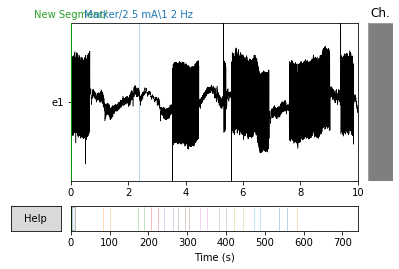

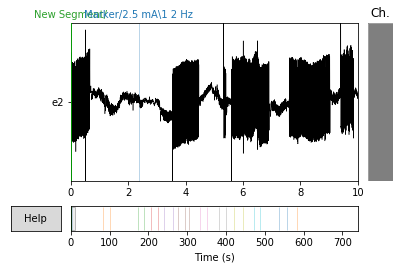

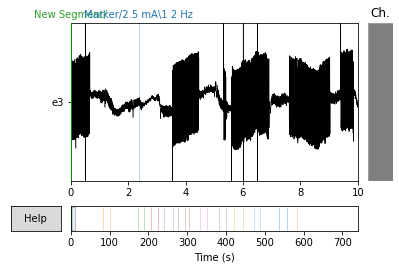

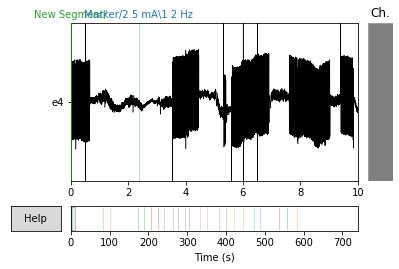

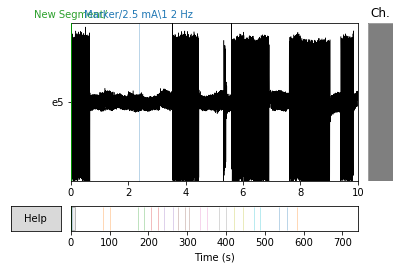

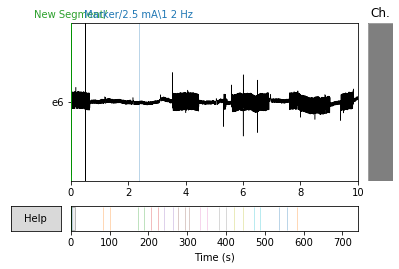

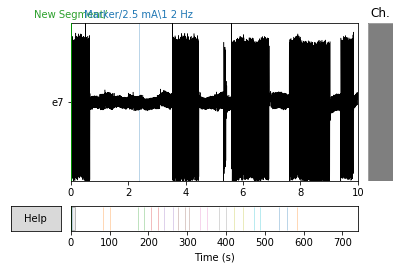

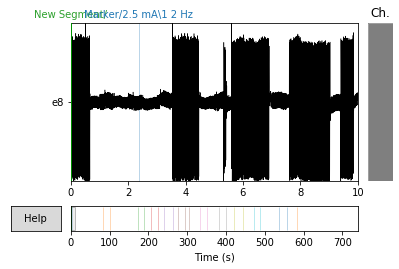

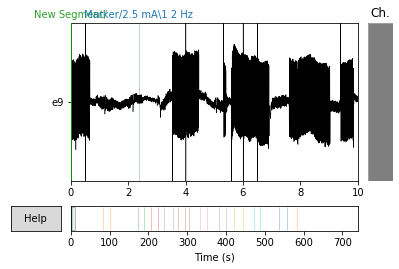

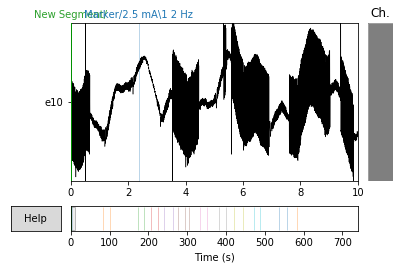

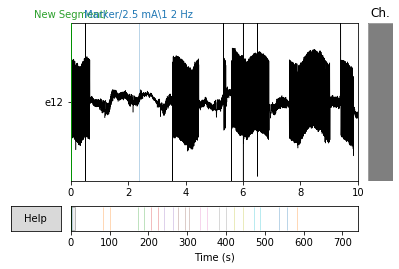

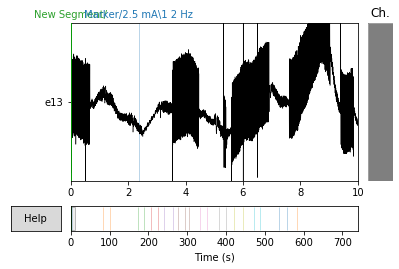

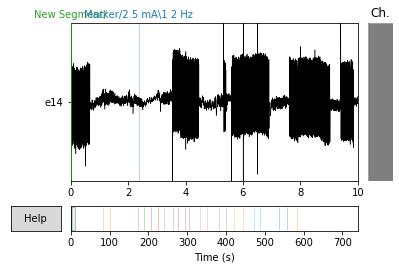

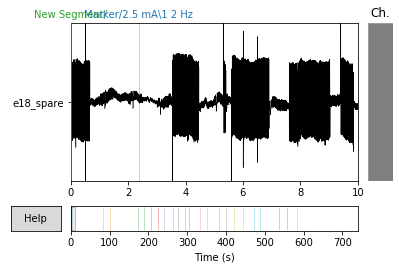

In [4]:
for i in range(14):
    raw.plot(n_channels=1, order=[i], scalings={'eeg': 0.001})

In [5]:
raw.info['bads'] = ['STI 014', '33']
raw_data = raw.get_data()[:14]

channel_ids = [0, 1, 2, 3, 8, 9, 10, 11, 12, 13]

recorded_data = raw_data[channel_ids]
common_avg = np.mean(recorded_data, axis=0)
# common_avg = np.mean(raw_data, axis=0)

recorded_data_common_avg = recorded_data - common_avg

# for i in range(recorded_data.shape[0]):
#     plt.figure()
#     plt.plot(recorded_data_common_avg[i])
#     plt.plot(recorded_data[i])
    

raw_common_avg_info = mne.create_info(
    ch_names=['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10'],
    sfreq=2048, ch_types='eeg'
)
raw_common_avg = mne.io.RawArray(recorded_data_common_avg, raw_common_avg_info)


Creating RawArray with float64 data, n_channels=10, n_times=1514304
    Range : 0 ... 1514303 =      0.000 ...   739.406 secs
Ready.


In [6]:

raw_common_avg.load_data()
raw_common_avg.filter(l_freq=0.5, h_freq=1000)
raw_common_avg.notch_filter(freqs=50, notch_widths=9)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+03 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 1000.00 Hz
- Upper transition bandwidth: 24.00 Hz (-6 dB cutoff frequency: 1012.00 Hz)
- Filter length: 13517 samples (6.600 sec)

Setting up band-stop filter from 45 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 45.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 44.75 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition 

<RawArray  |  None, n_channels x n_times : 10 x 1514304 (739.4 sec), ~115.6 MB, data loaded>

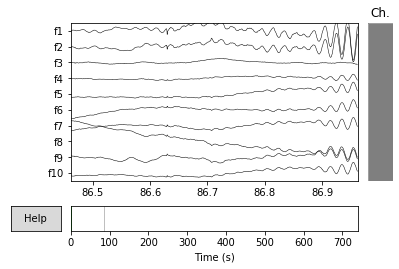

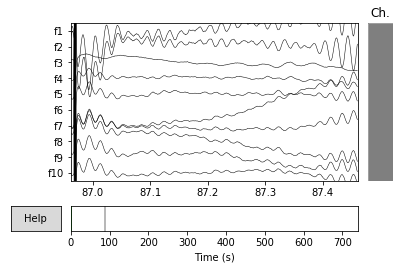

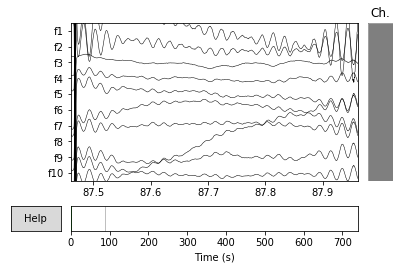

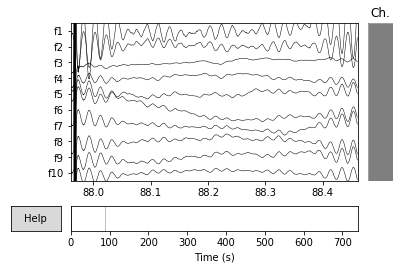

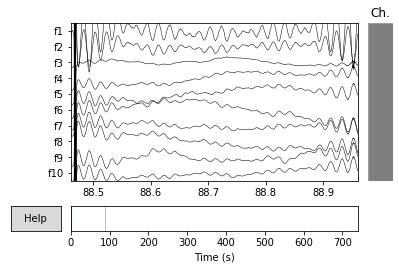

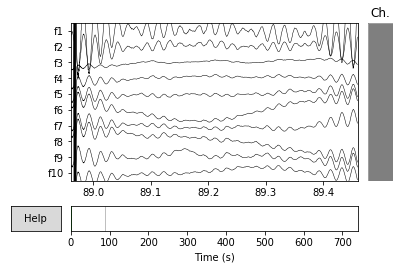

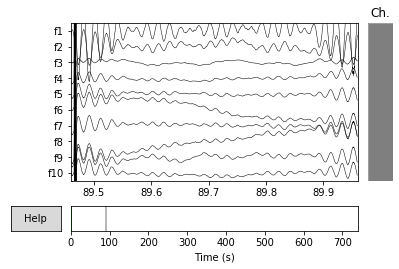

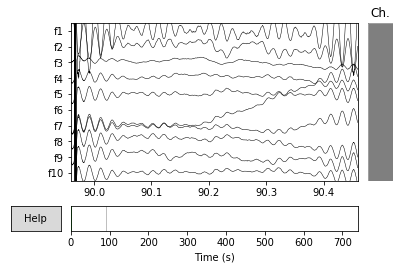

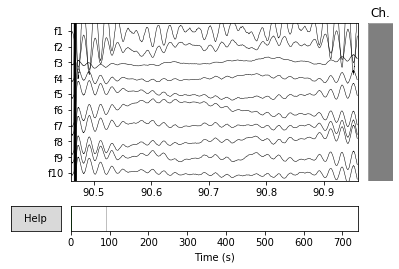

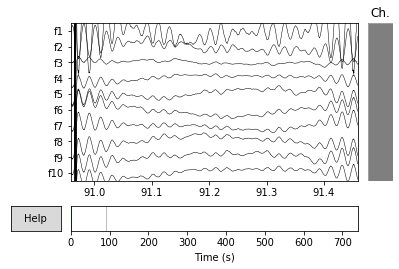

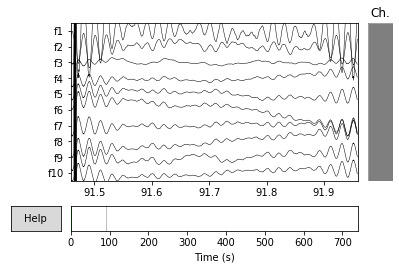

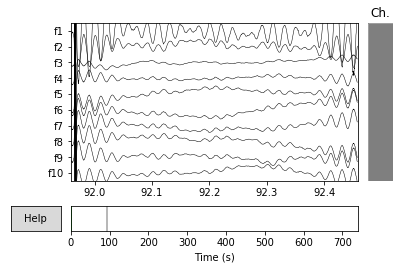

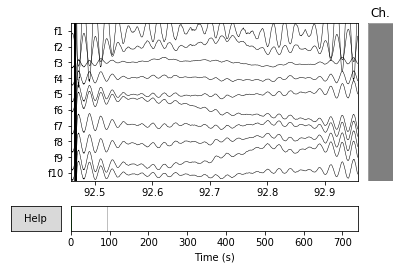

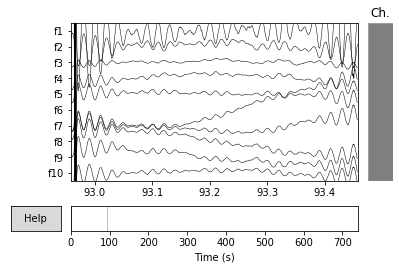

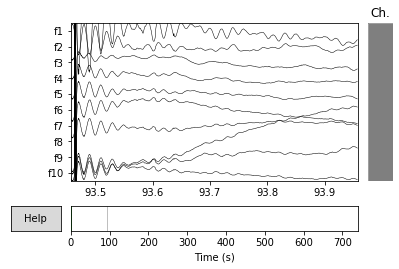

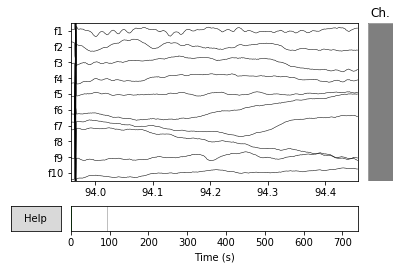

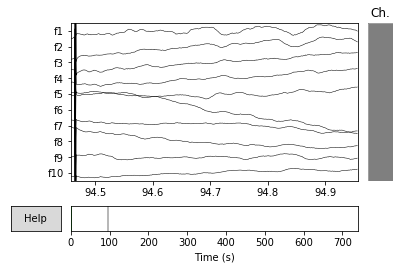

OK


In [7]:
stim_id = 0

events_range = np.arange(
    events_data.loc[stim_id]['time_begin'],
    events_data.loc[stim_id]['time_end'],
    events_data.loc[stim_id]['time_interval']
)

# events_range = np.arange(
#     86.462,
#     94.6,
#     0.4999
# )

for t_start in events_range:
    raw_common_avg.plot(start=t_start, duration=events_data.loc[stim_id]['time_interval'], n_channels=10, scalings={'eeg': 0.0001})
#     raw.plot(start=t_start, duration=0.4999, order=[0, 4], n_channels=2, scalings={'eeg': 0.001})
#     raw_common_avg.plot(start=t_start, duration=0.4999, n_channels=1, scalings={'eeg': 0.001})

print("OK")

In [18]:
from scipy import stats

z_score_threshold = 5

for event_record in events_data.iterrows():

    events_range = np.arange(
        event_record[1]['time_begin'] + event_record[1]['time_interval'],
        event_record[1]['time_end'],
        event_record[1]['time_interval']
    )

    artifact_onsets = []
    for t_start in events_range:

        raw_data = raw.copy().crop(tmin=t_start, tmax=t_start + event_record[1]['time_interval']).get_data()
        z_score_data = stats.zscore(np.max(np.abs(raw_data), axis=0))
        
        artifact_onsets.append(np.argmax(z_score_data > z_score_threshold))

#     print(artifact_onsets)
    print(
#          np.round(np.median(artifact_onsets)), 
         np.round(
            event_record[1]['time_begin'] + (np.median(artifact_onsets)) / raw.info['sfreq'], 3
        )
    )

86.469
190.915
210.404
262.876
309.352
352.83
387.811
431.788
470.768
541.231


In [118]:
t_event_1_beg = events_data.loc[stim_id]['time_begin'] + events_data.loc[stim_id]['time_interval']
t_event_1_end = events_data.loc[stim_id]['time_end'] - events_data.loc[stim_id]['time_interval']
t_interval = events_data.loc[stim_id]['time_interval']

events = np.empty((0, 3), dtype=int)

for t_start in np.arange(t_event_1_beg, t_event_1_end, t_interval):
    events = np.vstack([
        events, 
        np.array([raw_common_avg.time_as_index(t_start), 0, 1], dtype=int)
    ])

event_id = dict(stimulation=1)

t_min = 0
t_max = events_data.loc[stim_id]['time_interval']

epochs = mne.Epochs(raw_common_avg, events, event_id, t_min, t_max, baseline=(events_data.loc[stim_id]['time_interval'] - 0.005, events_data.loc[stim_id]['time_interval']))

15 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


Loading data for 15 events and 1025 original time points ...
0 bad epochs dropped
Loading data for 15 events and 1025 original time points ...
Loading data for 15 events and 1025 original time points ...


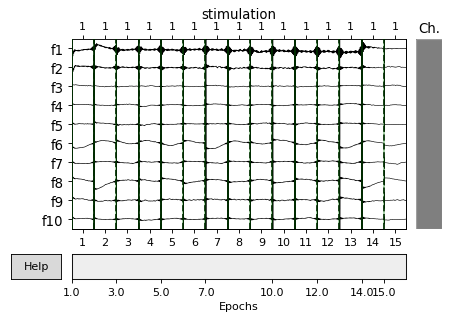

OK


In [119]:
epochs.get_data()
epochs.plot(n_channels=10, scalings={'eeg': 0.001})

print("OK")

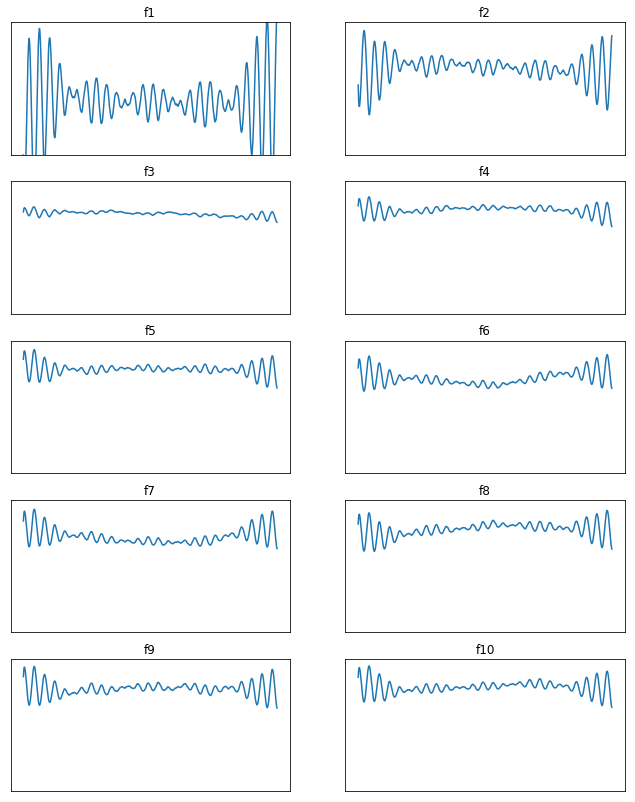

In [120]:
plt.figure(figsize=(11,20))

for i in range(10):
    avg_data = epochs.average(picks=[i]).crop(tmin=0.01).data
    avg_channel_name = epochs.average(picks=[i]).crop(tmin=0.01).ch_names[0]
    plt.subplot(7, 2, i+1)
    plt.plot(avg_data.T)
    plt.ylim([-0.0005, 0.0002])
    plt.xticks([])
    plt.yticks([])
    plt.title(avg_channel_name)
    
plt.savefig("stim_s%d.png" % stim_id)


time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-112-23a8dd4419c4>:1: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs.average(picks=[4]).crop(tmin=0.01).plot()


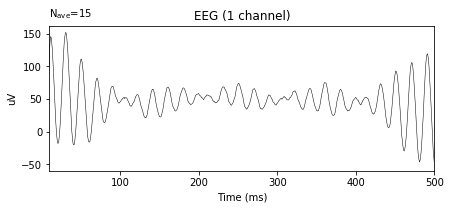

In [112]:
epochs.average(picks=[4]).crop(tmin=0.01).plot()
None